In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu, stats as ss
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2
from statsmodels.sandbox.stats.multicomp import multipletests

from tqdm.auto import tqdm

plt.style.use('ggplot')

**Информация о пользователях, которые посещали приложение во время эксперимента:**

* user_id — идентификатор пользователя (уникальный)
* country — страна посещения приложения (Россия, Швеция)
* platform — платформа посещения приложения (IOS, Android)
* sex — пол пользователя (мужской, женский)

In [3]:
active_users = pd.read_csv('Проект_4_active_users.csv',sep=",")
active_users.head()

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [4]:
#количество пользователей в эксперименте
active_users.shape[0]

8341

In [5]:
active_users.user_id.nunique()

8341

In [6]:
#разбивка пользователей на контрольную (А) и тестовую (В) группы.
groupAB_users = pd.read_csv('Проект_4_groups.csv',sep=",")
groupAB_users.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [7]:
groupAB_users.shape

(74576, 2)

In [8]:
#Все user оказались уникальными
groupAB_users.user_id.nunique()

74576

In [9]:
#Количество участия одного пользователя в эксперименте, все участвовали по одному разу.
groupAB_users.groupby('user_id', as_index=False)\
            .agg({'group': 'count'})\
            .rename(columns = {'group': 'number_participants'})\
            .sort_values(['number_participants'], ascending=[True])

,user_id,number_participants
0,0,1
49721,50380,1
49720,50379,1
49719,50378,1
49718,50377,1
...,...,...
24855,25514,1
24854,25513,1
24853,25512,1
24833,25492,1


**Таблица с покупками:**

* user_id —  уникальный идентификатор пользователя
* revenue —  доход с пользователя во время эксперимента

In [10]:
purchases  = pd.read_csv('Проект_4_purchases.csv',sep=",")
purchases.head()

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0


In [11]:
purchases.shape

(541, 2)

In [12]:
#нет повторных покупок
purchases.user_id.nunique()

541

In [13]:
#объединение таблиц покупки с группами в эксперименте
purchase_with_groupAB = pd.merge(groupAB_users, purchases, on=['user_id'],how='left')
purchase_with_groupAB['revenue'] = purchase_with_groupAB['revenue'].fillna(0)

In [14]:
#доход с разных групп во время эксперимента
purchase_with_groupAB.groupby('group', as_index=False)\
            .agg({'revenue': 'sum'})
            

,group,revenue
0,A,93162.0
1,B,485575.0


In [15]:
#объединение таблиц информация о пользователей с группами в эксперименте
active_users_with_groupAB = pd.merge(groupAB_users, active_users, on=['user_id'])
active_users_with_groupAB

,user_id,group,country,platform,sex
0,1488,B,Russia,android,male
1,5125,B,Russia,ios,female
2,3196,A,Russia,ios,female
3,1749,B,Russia,android,male
4,4994,B,Sweden,android,male
...,...,...,...,...,...
8336,1010,B,Sweden,android,male
8337,7785,A,Sweden,android,male
8338,1783,B,Russia,ios,female
8339,1164,A,Sweden,android,male


In [16]:
#Количество пользователей с разных групп во время эксперимента
active_users_with_groupAB.groupby('group', as_index=False)\
            .agg({'user_id': 'count'})

,group,user_id
0,A,1538
1,B,6803


In [17]:
#объединение таблиц покупки с группами в эксперименте и информацией о пользователе
user_purchase_with_groupAB = pd.merge(active_users_with_groupAB, purchases, on=['user_id'],how='left')
user_purchase_with_groupAB['revenue'] = user_purchase_with_groupAB['revenue'].fillna(0)
user_purchase_with_groupAB

,user_id,group,country,platform,sex,revenue
0,1488,B,Russia,android,male,0.0
1,5125,B,Russia,ios,female,0.0
2,3196,A,Russia,ios,female,0.0
3,1749,B,Russia,android,male,0.0
4,4994,B,Sweden,android,male,0.0
...,...,...,...,...,...,...
8336,1010,B,Sweden,android,male,0.0
8337,7785,A,Sweden,android,male,0.0
8338,1783,B,Russia,ios,female,0.0
8339,1164,A,Sweden,android,male,0.0


In [18]:
user_purchase_with_groupAB.groupby('platform', as_index=False)\
            .agg({'user_id': 'count'})

,platform,user_id
0,android,4621
1,ios,3720


In [19]:
user_purchase_with_groupAB.groupby('platform', as_index=False)\
            .agg({'revenue': 'sum'})

,platform,revenue
0,android,248180.0
1,ios,223531.0


In [20]:
user_avg = user_purchase_with_groupAB.groupby(['group','platform'], as_index=False)\
            .agg({'revenue': 'sum','user_id': 'count' })

In [21]:
user_avg['avg'] = user_avg.revenue/user_avg.user_id

In [22]:
user_avg

,group,platform,revenue,user_id,avg
0,A,android,39898.0,834,47.839329
1,A,ios,33700.0,704,47.869318
2,B,android,208282.0,3787,54.999208
3,B,ios,189831.0,3016,62.941313


In [23]:
def fun_CR (a):
    """Расчет CR"""
    a_A = a.query('group == "A"')
    a_B = a.query('group == "B"')
    CR_all = round(a.query('revenue>0').shape[0]/a.shape[0]*100,5)
    CR_A = round(a_A.query('revenue>0').shape[0]/a_A.shape[0]*100,5)
    CR_B = round(a_B.query('revenue>0').shape[0]/a_B.shape[0]*100,5)
    print(f'CR_all,%:', CR_all)
    print(f'CR_A,%:', CR_A)
    print(f'CR_B,%:', CR_B)

In [89]:
def fun_chi2 (b):
    """Функция для использования хи2 с решением по гипотезам"""
    stat, p, dof, expected = chi2_contingency(pd.crosstab(b.CR, b.group))
    print(stat, p)
    p_value = p
    prob = 0.95
    alpha = 1.0 - prob
    if p <= alpha:
        print('Отклоняем H0')
    else:
        print('Не отклоняем H0')
    return p_value

In [80]:
def fun_arpu (a):
    """Расчет ARPU"""
    a_A = a.query('group == "A"')
    a_B = a.query('group == "B"')
    ARPU_all = round(a['revenue'].sum()/a.shape[0],2)
    ARPU_A = round(a_A['revenue'].sum()/a_A.shape[0],2)
    ARPU_B = round(a_B['revenue'].sum()/a_B.shape[0],2)
    print(f'ARPU_all:', ARPU_all)
    print(f'ARPU_A:', ARPU_A )
    print(f'ARPU_B:', ARPU_B)

In [81]:
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):

    """Функция, которая позволит проверять гипотезы с помощью бутстрапа MEAN"""
 
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [82]:
def fun_user_pay (a):   
    """Расчет количества платящих пользователей"""
    a_A = a.query('group == "A"')
    a_B = a.query('group == "B"')
    purchase_with_groupAB_pay = a.query('revenue>0')
    purchase_group_A_pay = a_A.query('revenue>0')
    purchase_group_B_pay = a_B.query('revenue>0')
    users_purchase_all = purchase_with_groupAB_pay.shape[0]
    users_purchase_A = purchase_group_A_pay.shape[0]
    users_purchase_B = purchase_group_B_pay.shape[0]
    print(f'Number of all users who pay:', users_purchase_all)
    print(f'Number of all users who pay in A:', users_purchase_A)
    print(f'Number of all users who pay in B:', users_purchase_B)

In [88]:
def fun_mann (b):
    """Функция для решения по гипотезам по Mann-Whitney U test"""
    b_A = b.query('group == "A"')
    b_B = b.query('group == "B"')
    data1 = b_B.revenue
    data2 = b_A.revenue
    # compare samples
    stat, p = mannwhitneyu(data1, data2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    p_value = p
    prob = 0.95
    alpha = 1.0 - prob
    if p <= alpha:
        print('Отклоняем H0')
    else:
        print('Не отклоняем H0')
    return p_value

In [84]:
def fun_arppu (a):
    """Расчет ARPPU """
    a_A = a.query('group == "A"')
    a_B = a.query('group == "B"')
    ARPPU_all = round(a.query('revenue>0')['revenue'].sum()/a.query('revenue>0').shape[0],2)
    ARPPU_A = round(a_A.query('revenue>0')['revenue'].sum()/a_A.query('revenue>0').shape[0],2)
    ARPPU_B = round(a_B.query('revenue>0')['revenue'].sum()/a_B.query('revenue>0').shape[0],2)
    print(f'ARPPU_all:', ARPPU_all)
    print(f'ARPPU_A:', ARPPU_A )
    print(f'ARPPU_B:', ARPPU_B)

**Метрики без деления на платформы IOS и Android:**

* Конверсия в покупку
* Средняя выручка на пользователя=Средний чек на пользователя
* Средняя выручка на платящего пользователя=Средний чек на платящего пользователя
* Количество платящих пользователей

In [30]:
purchase_with_groupAB['CR'] = np.where(purchase_with_groupAB.revenue > 0, 1, 0)

In [31]:
purchase_group_A = purchase_with_groupAB.query('group=="A"')
purchase_group_B = purchase_with_groupAB.query('group=="B"')

In [32]:
#Конверсия в покупку CR для всех пользователей
fun_CR(purchase_with_groupAB)

CR_all,%: 0.72543
CR_A,%: 0.72824
CR_B,%: 0.72475


**Проверяем (тестируем) гипотезу с помощью ХИ-квадрат**<br/>
H0: CR в тестовой группе A **значимо не отличается** от CR в группе B<br/>
H1: CR в тестовой группе A **значимо отличается** от CR в группе B

In [92]:
p1 = fun_chi2 (purchase_with_groupAB)
print(p1)

0.0 1.0
Не отклоняем H0
1.0


In [34]:
#Средняя выручка на пользователя ARPU для всех пользователей
fun_arpu(purchase_with_groupAB)

ARPU_all: 7.76
ARPU_A: 6.34
ARPU_B: 8.11


**Проверяем (тестируем) гипотезу с помощью Манн-Уитни**<br/>
H0: Распределение ARPU выборки группы А **значимо не отличается** от группы B <br/>
H1: Распределение ARPU выборки группы А **значимо отличается** от группы B

In [93]:
p2 = fun_mann (purchase_with_groupAB)
print(p2)

Statistics=439920619.500, p=0.977
Не отклоняем H0
0.9771622986988255


In [36]:
#количество платящих пользователей
fun_user_pay (purchase_with_groupAB)

Number of all users who pay: 541
Number of all users who pay in A: 107
Number of all users who pay in B: 434


In [37]:
#Средняя выручка на платящего пользователя ARPPU для всех пользователей
fun_arppu(purchase_with_groupAB)

ARPPU_all: 1069.75
ARPPU_A: 870.67
ARPPU_B: 1118.84


**Проверяем (тестируем) гипотезу с помощью bootstrap MEAN**<br/>
H0: Средняя выручка на платящего пользователя в тестовой группе A **значимо не отличается** от группы B B<br/>
H1: Средняя выручка на платящего пользователя в тестовой группе A  **значимо отличается** от группы B

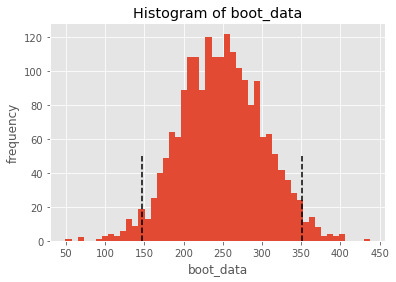

2.46965748779544e-06
Отклоняем H0


In [95]:
booted_data_mean_pay = get_bootstrap_mean(\
    purchase_with_groupAB.query('group == "B" and revenue>0').revenue, \
    purchase_with_groupAB.query('group == "A" and revenue>0').revenue, \
    boot_it = 2000) 
# в результате хранится разница двух распределений, ДИ и pvalue
print(booted_data_mean_pay["p_value"])
prob = 0.95
alpha = 1.0 - prob
if booted_data_mean_pay["p_value"] <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')
p3 = booted_data_mean_pay["p_value"]
#P_value<0.05 это означает, что отвергаем H0 и принимаем H1, 
#то что средняя выручка Средняя выручка на платящего пользователя в тестовой группе A 
#ЗНАЧИМО отличается от средней выручки на платящего пользователя в группе B

**Метод Холма**

In [96]:
print(sorted([p1, p2, p3]))

print("FWER: " + str(multipletests(sorted([p1, p2, p3]), alpha=0.05, 
                     method='holm', is_sorted = True)))
#С корректировкой по методу Холма получилось, что ARPPU действительно отличается у двух групп, а другие показатели
#действительно отличаются.


[2.46965748779544e-06, 0.9771622986988255, 1.0]
FWER: (array([ True, False, False]), array([7.40897246e-06, 1.00000000e+00, 1.00000000e+00]), 0.016952427508441503, 0.016666666666666666)


**Метрики с деления на платформы IOS и Android:**

* Конверсия в покупку
* Средняя выручка на пользователя = Средний чек на пользователя
* Средняя выручка на платящего пользователя = Средний чек на платящего пользователя
* Количество платящих пользователей

In [39]:
#объединение таблиц характеристики пользователей с покупками
user_purchase_with_info = pd.merge(active_users, purchases, on=['user_id'],how='left')
user_purchase_with_info['revenue'] = user_purchase_with_info['revenue'].fillna(0)
user_purchase_with_info['CR'] = np.where(user_purchase_with_info.revenue > 0, 1, 0)

In [40]:
user_purchase_with_info

,user_id,country,platform,sex,revenue,CR
0,8029,Russia,ios,male,0.0,0
1,1735,Sweden,ios,male,0.0,0
2,7697,Russia,android,male,0.0,0
3,1421,Sweden,android,female,0.0,0
4,1704,Russia,ios,male,0.0,0
...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,0.0,0
8337,3755,Russia,ios,male,590.0,1
8338,4594,Sweden,android,female,0.0,0
8339,7430,Sweden,ios,female,0.0,0


In [41]:
#объединение таблиц характеристики пользователей с покупками и участием в эксперименте
user_purchase_with_info_AB = pd.merge(user_purchase_with_info, groupAB_users, on=['user_id'])
user_purchase_with_info_AB

,user_id,country,platform,sex,revenue,CR,group
0,8029,Russia,ios,male,0.0,0,B
1,1735,Sweden,ios,male,0.0,0,B
2,7697,Russia,android,male,0.0,0,B
3,1421,Sweden,android,female,0.0,0,B
4,1704,Russia,ios,male,0.0,0,B
...,...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,0.0,0,B
8337,3755,Russia,ios,male,590.0,1,A
8338,4594,Sweden,android,female,0.0,0,B
8339,7430,Sweden,ios,female,0.0,0,B


In [42]:
#деление по тестовой и контрольной группе
user_purchase_with_info_A = user_purchase_with_info_AB.query('group=="A"')
user_purchase_with_info_B = user_purchase_with_info_AB.query('group=="B"')

In [43]:
#IOS
user_purchase_AB_IOS = user_purchase_with_info_AB.query('platform=="ios"')
user_purchase_A_IOS = user_purchase_with_info_A.query('platform=="ios"')
user_purchase_B_IOS = user_purchase_with_info_B.query('platform=="ios"')

In [44]:
#Конверсия в покупку CR для всех IOS
fun_CR(user_purchase_AB_IOS)

CR_all,%: 4.94624
CR_A,%: 5.53977
CR_B,%: 4.80769


**Проверяем (тестируем) гипотезу с помощью ХИ-квадрат**<br/>
H0: CR в тестовой группе A **значимо не отличается** от CR в группе B<br/>
H1: CR в тестовой группе A **значимо отличается** от CR в группе B

In [72]:
fun_chi2 (user_purchase_AB_IOS)

0.5042373308565214 0.4776441693023915
Не отклоняем H0


0.4776441693023915

In [46]:
#Android
user_purchase_AB_Android = user_purchase_with_info_AB.query('platform=="android"')
user_purchase_A_Android = user_purchase_with_info_A.query('platform=="android"')
user_purchase_B_Android = user_purchase_with_info_B.query('platform=="android"')

In [47]:
#Конверсия в покупку CR для Android
fun_CR(user_purchase_AB_Android)

CR_all,%: 4.50119
CR_A,%: 4.67626
CR_B,%: 4.46264


**Проверяем (тестируем) гипотезу с помощью ХИ-квадрат**<br/>
H0: CR в тестовой группе A **значимо не отличается** от CR в группе B<br/>
H1: CR в тестовой группе A **значимо отличается** от CR в группе B

In [48]:
fun_chi2 (user_purchase_AB_Android)

0.03137316416817135 0.8594104301864645
Не отклоняем H0


In [49]:
#Средняя выручка на пользователя ARPU для IOS
fun_arpu(user_purchase_AB_IOS)

ARPU_all: 60.09
ARPU_A: 47.87
ARPU_B: 62.94


**Проверяем (тестируем) гипотезу с помощью Манн-Уитни**<br/>
H0: Распределение ARPU выборки группы А **значимо не отличается** от группы B <br/>
H1: Распределение ARPU выборки группы А **значимо отличается** от группы B

In [50]:
fun_mann(user_purchase_AB_IOS)

Statistics=1054794.000, p=0.478
Не отклоняем H0


In [51]:
#Средняя выручка на пользователя ARPU для Android
fun_arpu(user_purchase_AB_Android)

ARPU_all: 53.71
ARPU_A: 47.84
ARPU_B: 55.0


**Проверяем (тестируем) гипотезу с помощью Манн-Уитни**<br/>
H0: Распределение ARPU выборки группы А **значимо не отличается** от группы B <br/>
H1: Распределение ARPU выборки группы А **значимо отличается** от группы B

In [52]:
fun_mann(user_purchase_AB_Android)

Statistics=1576471.000, p=0.829
Не отклоняем H0


In [53]:
#количество платящих пользователей для IOS
fun_user_pay (user_purchase_AB_IOS)

Number of all users who pay: 184
Number of all users who pay in A: 39
Number of all users who pay in B: 145


In [54]:
#Средняя выручка на платящего пользователя ARPPU для IOS
fun_arppu(user_purchase_AB_IOS)

ARPPU_all: 1214.84
ARPPU_A: 864.1
ARPPU_B: 1309.18


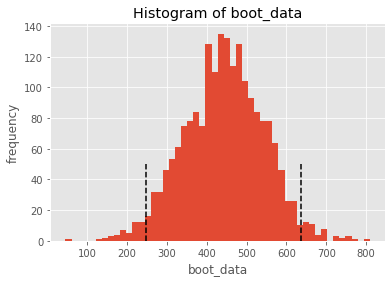

8.749223957654438e-06
Отклоняем H0


In [55]:
#Проверяем (тестируем) гипотезу 
#H0:Средняя выручка на платящего пользователя в тестовой группе A 
#НЕ ЗНАЧИМО ОТЛИЧАЕТСЯ от средней выручки на платящего пользователя в группе B
#H1:Средняя выручка на платящего пользователя в тестовой группе A 
#ЗНАЧИМО отличается от средней выручки на платящего пользователя в группе B
#Проверка гипотезы 
booted_data_mean_pay_IOS = get_bootstrap_mean(\
    user_purchase_AB_IOS.query('group == "B" and revenue>0').revenue, \
    user_purchase_AB_IOS.query('group == "A" and revenue>0').revenue, \
    boot_it = 2000) 
# в результате хранится разница двух распределений, ДИ и pvalue
print(booted_data_mean_pay_IOS["p_value"])
prob = 0.95
alpha = 1.0 - prob
if booted_data_mean_pay_IOS["p_value"] <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')
#P_value<0.05 это означает, что отвергаем H0 и принимаем H1, 
#то что средняя выручка Средняя выручка на платящего пользователя в тестовой группе A 
#ЗНАЧИМО отличается от средней выручки на платящего пользователя в группе B

In [56]:
#Количество платящих пользователей для Android
fun_user_pay (user_purchase_AB_Android)

Number of all users who pay: 208
Number of all users who pay in A: 39
Number of all users who pay in B: 169


In [57]:
#Средняя выручка на платящего пользователя ARPPU для Android
fun_arppu(user_purchase_AB_Android)

ARPPU_all: 1193.17
ARPPU_A: 1023.03
ARPPU_B: 1232.44


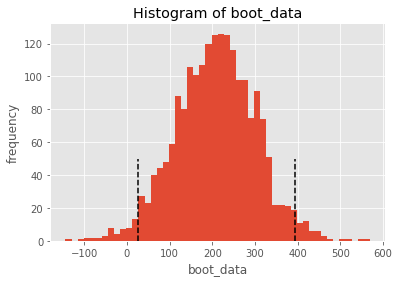

0.025568134552647465
Отклоняем H0


In [58]:
#Проверка гипотезы 
booted_data_mean_pay_Android = get_bootstrap_mean(\
    user_purchase_AB_Android.query('group == "B" and revenue>0').revenue, \
    user_purchase_AB_Android.query('group == "A" and revenue>0').revenue, \
    boot_it = 2000)  
# в результате хранится разница двух распределений, ДИ и pvalue
print(booted_data_mean_pay_Android["p_value"])
prob = 0.95
alpha = 1.0 - prob
if booted_data_mean_pay_Android["p_value"] <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')
#P_value<0.05 это означает, что отвергаем H0 и принимаем H1, 
#то что средняя выручка Средняя выручка на платящего пользователя в тестовой группе A 
#ЗНАЧИМО отличается от средней выручки на платящего пользователя в группе B

**Пользователи по странам**

In [59]:
#страна Россия и Швеция
user_ru = user_purchase_with_info_AB.query('country=="Russia"')
user_swe = user_purchase_with_info_AB.query('country=="Sweden"')

In [60]:
#количество пользователей стран
number_user_ru = user_ru.shape[0]
number_user_swe = user_swe.shape[0]
number_user_ru, number_user_swe

(5407, 2934)

In [61]:
#Конверсия в покупку CR для России
fun_CR(user_ru)

CR_all,%: 4.43869
CR_A,%: 4.69945
CR_B,%: 4.38557


**Проверяем (тестируем) гипотезу с помощью ХИ-квадрат**<br/>
H0: CR в тестовой группе A **значимо не отличается** от CR в группе B<br/>
H1: CR в тестовой группе A **значимо отличается** от CR в группе B

In [62]:
fun_chi2(user_ru)

0.11031466555016003 0.7397861776034413
Не отклоняем H0


In [63]:
#Конверсия в покупку CR для Швеции
fun_CR(user_swe)

CR_all,%: 5.18064
CR_A,%: 5.61798
CR_B,%: 5.06274


**Проверяем (тестируем) гипотезу с помощью ХИ-квадрат**<br/>
H0: CR в тестовой группе A **значимо не отличается** от CR в группе B<br/>
H1: CR в тестовой группе A **значимо отличается** от CR в группе B

In [64]:
fun_chi2(user_swe)

0.2053045758880742 0.6504727896095026
Не отклоняем H0
